<a href="https://colab.research.google.com/github/strathpaulkirkland/DM996/blob/master/DM996_Lab2_CNN_Transfer_Learning_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2: Classification of MNIST Dreams with Convolutional Neural Networks

Next, let's build a convolutional neural network (CNN) classifier to classify images of handwritten digits in the MNIST dataset with a twist where we test our classifier on high-resolution hand-written digits from outside the dataset.

The CNN is the most typical network used for image based problem due to the nature in which is related to how our visual fields process information within our brains.

Once again set up the environement with the packages you want to use. 

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

!cat /proc/cpuinfo # gives details of CPU

!nvidia-smi # gives details of GPU

# !pip uninstall tensorflow  #just incase you want to change version
# !pip install tensorflow==2.X.0
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import os, datetime
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.200
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

The MNIST dataset containss 70,000 grayscale images of handwritten digits at a resolution of 28 by 28 pixels. The task is to take one of these images as input and predict the most likely digit contained in the image (along with a relative confidence in this prediction):

<img src="https://i.imgur.com/ITrm9x4.png" width="500px">

Now, we load the dataset. The images are 28x28 NumPy arrays, with pixel values ranging between 0 and 255. The *labels* are an array of integers, ranging from 0 to 9.

In [1]:
# import the mnist dataset from keras
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()# This line imports the mnist dataset from keras, it consists of train_images, train_labels, test_images and test_labels

# reshape the train images to include an additional dimension for a single channel
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1) 
# This line reshape the train images to include an additional dimension for a single channel, 
# the first parameter is the number of images, and the last parameter is the number of channels
# the values of 28 are the size of the image 28x28

# reshape the test images to include an additional dimension for a single channel
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1) # This line reshape the test images to include an additional dimension for a single channel, the first parameter is the number of images, and the last parameter is the number of channels


# return the modified images
print("Train Images shape: ",train_images.shape)
print("Test Images shape: ",test_images.shape)

NameError: ignored

We scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [ ]:
def preprocess_images(imgs): # should work for both a single image and multiple images
    # check if the shape of the input image is 2D, and if so, assign it to `sample_img`
    sample_img = imgs if len(imgs.shape) == 2 else imgs[0]
    # assert that the shape of the image is 28x28 and single-channel (grayscale)
    assert sample_img.shape in [(28, 28, 1), (28, 28)], sample_img.shape 
    # normalize the image by dividing each pixel by 255.0
    return imgs / 255.0

# preprocess the train images
train_images = preprocess_images(train_images)

# preprocess the test images
test_images = preprocess_images(test_images)

Display the first 5 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

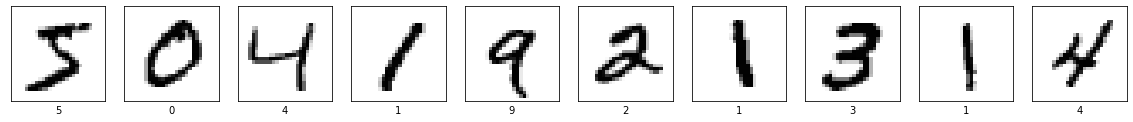

In [ ]:
# create a figure with a specific size
plt.figure(figsize=(20,4))
# loop through the first 10 images in the train dataset
for i in range(10):
    # add a subplot to the figure
    plt.subplot(1,10,i+1)
    # remove the x-axis ticks
    plt.xticks([])
    # remove the y-axis ticks
    plt.yticks([])
    # remove grid
    plt.grid(False)
    # display the image
    plt.imshow(train_images[i].reshape(28, 28), cmap=plt.cm.binary)# This line displays the image on the subplot, reshaping it to 28 by 28 pixels and using the 'binary' colormap
    # add the label of the image to the x-axis
    plt.xlabel(train_labels[i])

### Build the model

Building the neural network requires configuring the layers of the model, then compiling the model. In many cases, this can be reduced to simply stacking together layers:

This script is defining a convolutional neural network model using the Keras library. The model is a sequential model where we stack layers on top of each other. The model starts with a 2D convolution layer with 32 filters of size 3x3 and relu activation as the input shape. Then it has another 2D convolution layer with 64 filters of size 3x3 and relu activation. Then it has a max pooling layer to choose the best features via pooling. Then it has a dropout layer to randomly turn neurons on and off to improve convergence. Then it flatten the data since too many dimensions, we only want a classification output. Then it has a fully connected layer with 128 neurons and relu activation, then another dropout layer to randomly turn neurons on and off to improve convergence and then the final output layer with 10 neurons and softmax activation. It also prints the summary of the model which shows the architecture of the model and number of parameters in each layer.

In [ ]:
# create a sequential model
model = keras.Sequential()

# add a 2D convolution layer with 32 filters of size 3x3 and relu activation
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# add a 2D convolution layer with 64 filters of size 3x3 and relu activation
model.add(Conv2D(64, (3, 3), activation='relu'))
# add a 2D pooling layer to choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
# add a dropout layer to randomly turn neurons on and off to improve convergence
# model.add(Dropout(0.25))
# flatten the data since too many dimensions, we only want a classification output
model.add(Flatten())
# add a fully connected layer with 128 neurons and relu activation
model.add(Dense(128, activation='relu'))
# add a dropout layer to randomly turn neurons on and off to improve convergence
# model.add(Dropout(0.5))
# add a final output layer with 10 neurons and softmax activation
model.add(Dense(10, activation='softmax'))

# print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:

* *Loss function* - measures how accurate the model is during training, we want to minimize this with the optimizer.
* *Optimizer* - how the model is updated based on the data it sees and its loss function.
* *Metrics* - used to monitor the training and testing steps. "accuracy" is the fraction of images that are correctly classified.

In [ ]:
#compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), 
              # set the optimizer as Adam with a learning rate of 0.1
              loss='sparse_categorical_crossentropy', 
              # use sparse categorical crossentropy as the loss function
              metrics=['accuracy']) 
              # track the accuracy metric during training


This script is compiling the model, in order to prepare the model for training. The compile() function takes three main arguments:



1.   Optimizer : which is used to minimize the loss function during the training process. The Adam optimizer is one of the most commonly used optimizers in deep learning, it's a variation of the stochastic gradient descent (SGD) algorithm which is computationally efficient and well suited for large datasets. The learning rate is set to 0.1, it controls how much the optimizer adjusts the weights of the network with respect to the loss gradient.
2.   Loss : which is used to measure the dissimilarity between the predicted and the actual probability distribution of the output classes, in this case sparse categorical crossentropy is used.
3.  Metrics : which are used to monitor the training and testing steps, here accuracy is used.

It is important to note that the optimizer, loss function and metrics are chosen based on the problem's nature and the model's architecture.

### Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model—in this example, the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. We ask the model to make predictions about a test set—in this example, the `test_images` array. We verify that the predictions match the labels from the `test_labels` array. 

To start training,  call the `model.fit` method—the model is "fit" to the training data:

In [ ]:
#extra code to use tensorboard if wanted
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
################################

# train the model
history = model.fit(train_images, train_labels, epochs=1, batch_size=64, callbacks=[tensorboard_callback]) 
# set the number of epochs to 1 and the batch size to 64

938/938 [==============================] - 11s 8ms/step - loss: 4.2727 - accuracy: 0.1043


This script is training the model on the train_images and train_labels dataset. The fit() function takes several arguments:

train_images: The training dataset images.
train_labels: The corresponding labels for the training dataset images.
epochs: The number of times the model will cycle through the data. One epoch is when an entire dataset is passed forward and backward through the neural network only once.
batch_size: The number of samples per gradient update. The model will update the weights after each batch.
callbacks: A list of callbacks to apply during training. TensorBoard is used for visualizing the training progress in this case, the logdir is set to where the tensorboard logs will be stored and histogram_freq=1 so that histograms of the weights and biases are written to the log every epoch.
It is important to note that the number of epochs and batch size are chosen based on the problem's nature and the model's architecture.

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 11% on the training data.

Did this take a while to run ???

If so check the Runtime - Change Runtime Type and ensure it is on GPU.


### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [ ]:

#print the shape of test images
print(test_images.shape)

#evaluate the model on test data
test_loss, test_acc = model.evaluate(test_images, test_labels)

#print the test accuracy
print('Test accuracy:', test_acc)

Often times, the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of *overfitting*. 
In our case, the accuracy is bad at 11%! 


In [ ]:
%tensorboard --logdir logs

# Improvement

Again this network can be improved. 

Look at the values of Learning Rate, Batch Size, Epochs and the model itself (Dropout layers)

# Get the Accuracy to 99% then continue


You can run the next section if you want to see how network performs, but it is rather slow, so wait until you have an improved network. 



---



---



---



##**Make predictions**

With the model trained, we can use it to make predictions about some images. Let's step outside the MNIST dataset for that and go with the beautiful high-resolution images generated by a mixture of CPPN, GAN, VAE. See [great blog post by hardmaru](http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/) for the source data and a description of how these morphed animations are generated:

![MNIST dream](https://i.imgur.com/OrUJs9V.gif)

In [ ]:

# Define the path to the sample video file
mnist_dream_path = 'https://github.com/strathpaulkirkland/DM996/raw/master/mnist_dream.mp4'
# Define the path to save the predicted video file
mnist_prediction_path = 'mnist_dream_predicted.mp4'

# Check if the file already exists, if not download the sample video
if not os.path.isfile(mnist_dream_path): 
    print('downloading the sample video...')
    vid_url = mnist_dream_path
    # Download the video file from the url and save it to the defined path
    mnist_dream_path = urllib.request.urlretrieve(vid_url)[0]
                                                                                                  
# Define a function to display an image using IPython library
def cv2_imshow(img):
    # Encode the image to .png format
    ret = cv2.imencode('.png', img)[1].tobytes() 
    # Create an IPython image object
    img_ip = IPython.display.Image(data=ret)
    # Display the image
    IPython.display.display(img_ip)

# Open a video capture object using the video file path
cap = cv2.VideoCapture(mnist_dream_path) 
# Initialize the variable vw (used for debugging if needed)
vw = None
# Initialize the variable frame to -1 (used for debugging if needed)
frame = -1 


######################################

Copy code
while True: # This line creates an infinite loop that will continue to execute the code within it until a specific condition is met (in this case, a break statement is used later in the code)
    frame += 1 # This line increments the value of the "frame" variable by 1 on each iteration of the loop
    ret, img = cap.read() # This line reads a frame from the video capture object "cap" and assigns the returned values to the variables "ret" and "img"
    if not ret: break # This line checks the value of the "ret" variable and, if it is False, breaks out of the loop (ending the infinite loop)
    assert img.shape[0] == img.shape[1] # This line asserts that the height and width of the image are equal (i.e. the image is a square)
    if img.shape[0] != 720: # This line checks if the height of the image is not equal to 720
        img = cv2.resize(img, (720, 720)) # If the height is not equal to 720, the image is resized to a height and width of 720 using the "cv2.resize" function
       
#preprocess the image for prediction
    img_proc = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # This line converts the image from BGR color space to grayscale using the "cv2.cvtColor" function
    img_proc = cv2.resize(img_proc, (28, 28)) # This line resizes the image to a width and height of 28 pixels using the "cv2.resize" function
    img_proc = preprocess_images(img_proc) #This line applies preprocessing function on the image
    img_proc = 1 - img_proc # This line inverses the image, since the training dataset is white text with black background
    net_in = np.expand_dims(img_proc, axis=0) # This line adds an extra dimension to the image array to specify a batch size of 1 using numpy expand_dims function
    net_in = np.expand_dims(net_in, axis=3) # This line adds an extra dimension to the image array to specify the number of channels using numpy expand_dims function
    preds = model.predict(net_in)[0] # This line uses the trained model to make a prediction on the preprocessed image
    guess = np.argmax(preds) # This line assigns the index of the highest predicted probability to the "guess" variable
    perc = np.rint(preds * 100).astype(int) # This line rounds the predicted probabilities to the nearest integer and converts them to integers
    
  
    img = 255 - img # this line inverts the color of the image by subtracting all pixel values from 255
    pad_color = 0 # this line sets the padding color to be black (0)
    img = np.pad(img, ((0,0), (0,1280-720), (0,0)), mode='constant', constant_values=(pad_color))  
    # this line pads the image with the pad_color (black) on the right side to make the image width 1280 pixels

    line_type = cv2.LINE_AA # this line sets the line type for the text to be anti-aliased
    font_face = cv2.FONT_HERSHEY_SIMPLEX # this line sets the font face to be simplex
    font_scale = 1.3 # this line sets the font scale to be 1.3 
    thickness = 2 # this line sets the thickness of the text to be 2
    x, y = 740, 60 # this line sets the x and y coordinates for the text to be placed at (740, 60)
    color = (255, 255, 255) # this line sets the color of the text to be white

    text = "Neural Network Output:" # this line sets the text to be written as "Neural Network Output:"
    cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                        color=color, lineType=line_type) 
    # this line writes the text "Neural Network Output:" on the image at the specified x and y coordinates with the specified font, font scale, thickness, color and line type.
    
    Copy code
text = "Input:" # this line sets the text to be written as "Input:"
cv2.putText(img, text=text, org=(30, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)   
# this line writes the text "Input:" on the image at the specified x, y coordinates with the specified font, font scale, thickness, color and line type.

y = 130 # this line sets the y coordinate for the next set of text and rectangles to be written at 130
for i, p in enumerate(perc):
    if i == guess: color = (255, 218, 158)
    else: color = (100, 100, 100)

    rect_width = 0
    if p > 0: rect_width = int(p * 3.3)

    rect_start = 180
    cv2.rectangle(img, (x+rect_start, y-5), (x+rect_start+rect_width, y-20), color, -1)
    # this line draws a rectangle on the image starting at (x+rect_start, y-5) and ending at (x+rect_start+rect_width, y-20) with the specified color and filled in.
    
    text = '{}: {:>3}%'.format(i, int(p))
    cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)
    # this line writes the text '{}: {:>3}%'.format(i, int(p)) on the image at the specified x, y coordinates with the specified font, font scale, thickness, color and line type.
    y += 60
    # this line increments the y coordinate by 60 for the next set of text and rectangles
    
    # if you don't want to save the output as a video, set this to False
    save_video = True
    
    if save_video:
        if vw is None:
            codec = cv2.VideoWriter_fourcc(*'MP4V')
            vid_width_height = img.shape[1], img.shape[0]
            vw = cv2.VideoWriter('mnist_dream_predicted.mp4', codec, 30, vid_width_height)
        # 15 fps above doesn't work robustly so we right frame twice at 30 fps
        vw.write(img)
        vw.write(img)
    
    # scale down image for display
    img_disp = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
    cv2_imshow(img_disp)
    IPython.display.clear_output(wait=True)
        
        #releasing all the stored information such as the frame to allow the process to move on
cap.release()
if vw is not None:
    vw.release()



1/1 [==============================] - 0s 24ms/step


In [ ]:
#Videos in Collab are a pain to play but this is a workaround

from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "/content/mnist_dream_predicted.mp4"

# Compressed video path
compressed_path = "/content/mnist_dream_predicted_C.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

The above shows the prediction of the network by choosing the neuron with the highest output. While the output layer values add 1 to one, these do not reflect well-calibrated measures of "uncertainty". Often, the network is overly confident about the top choice that does not reflect a learned measure of probability. If everything ran correctly you should get an animation like this:

![MNIST dream predictions](https://i.imgur.com/eMF9FOG.gif)